# Titanic dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import re
from collections import defaultdict

In [2]:
main_data = pd.read_csv("train.csv", index_col="PassengerId")
main_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [3]:
# Making communicative reference table.
variables = main_data.columns
definitions = ["Survival", "ticket class", "name", "sex", "age in years",
               "# of siblings/spouses aboard the Titanic",
               "# of parents/children aboard the Titanic", "ticket number", "passenger fare", "cabin number",
               "port of embarkation"]
keys = ["0 = No, 1 = Yes", "1st, 2nd, 3rd", "","", "", "", "", "", "", "", "Cherbourg, Queenstown, Southampton"]
len(variables), len(definitions), len(keys)

(11, 11, 11)

In [4]:
ref_table = pd.DataFrame([definitions, keys], columns=variables, index=["Definitions", "Keys"]).T
ref_table

,Definitions,Keys
Survived,Survival,"0 = No, 1 = Yes"
Pclass,ticket class,"1st, 2nd, 3rd"
Name,name,
Sex,sex,
Age,age in years,
SibSp,# of siblings/spouses aboard the Titanic,
Parch,# of parents/children aboard the Titanic,
Ticket,ticket number,
Fare,passenger fare,
Cabin,cabin number,


# Analysis

In [5]:
main_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Missing data:
main_data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
# Number of people died vs. number of people survived:
main_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Prepositions

In [8]:
# Using feature encoding and regex to get prepositions of names:
prepositions = list()
for person in main_data["Name"]:
    preposition = re.findall("[A-Z][a-z]+\.", person)
    if preposition not in prepositions:
        prepositions.append(preposition)

prepositions = np.array(prepositions).reshape(len(prepositions))
print(f"We have {len(prepositions)} prepositions: ")
print(prepositions)

We have 17 prepositions: 
['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'Countess.' 'Jonkheer.']


### Age

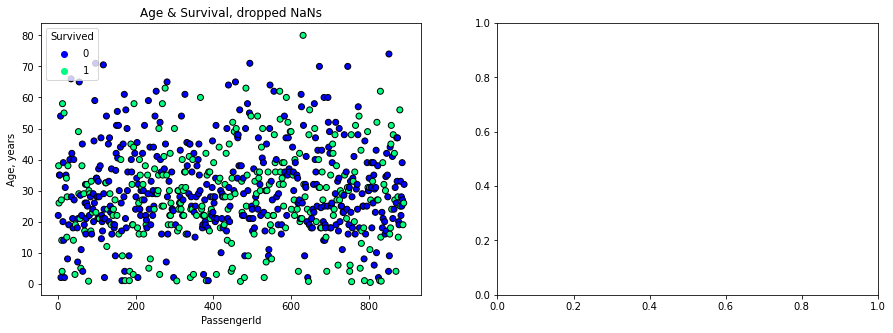

In [9]:
# Analyzing the ages of people (using scatterplot):

fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(15, 5))

# 1. Dropping NaNs:

y = main_data.dropna(subset=["Age"])["Age"]
x = main_data.dropna(subset=["Age"]).index
c = main_data.dropna(subset=["Age"])["Survived"]

scatter1 = ax1.scatter(x=x, y=y, c=c, cmap='winter', edgecolors='black')
ax1.legend(*scatter1.legend_elements(), title="Survived", loc='upper left')
ax1.set(title="Age & Survival, dropped NaNs",
        ylabel="Age, years",
        xlabel="PassengerId");

There is almost no pattern. Except, most children (age 0-10) survived the titanic. It means that they did it probably with parents (or mother at least). Let's try this hypothesis.

In [10]:
ch_10 = main_data[main_data["Age"] <= 10]
ch_10.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.593750,2.640625,4.268281,1.843750,1.421875,30.434439
std,0.495015,0.573687,2.976117,1.605731,0.528691,24.807302
min,0.000000,1.000000,0.420000,0.000000,0.000000,8.516700
25%,0.000000,2.000000,2.000000,0.750000,1.000000,19.131225
50%,1.000000,3.000000,4.000000,1.000000,1.000000,27.000000
75%,1.000000,3.000000,7.000000,3.250000,2.000000,31.387500
max,1.000000,3.000000,10.000000,5.000000,2.000000,151.550000


At average children under 10 had about 1.8 sibsp feature and 1.4 parch. It means that children were preferred for escape. Also, they took up far less space than average person.

Let's check the average "Survived" for different age groups:

In [11]:
probabilities = np.array([])
num_samples = np.array([])
years = np.array([i for i in range(0, 71, 10)])

for year in years:
    df = main_data[main_data["Age"] >= year]
    df = df[df["Age"] <= year + 10]
    prob = len(df[df["Survived"] == 1])/len(df)
    
    probabilities = np.append(probabilities, prob)
    num_samples = np.append(num_samples, len(df))
    
probabilities, num_samples, probabilities.mean(), len(main_data[main_data["Survived"] == 1])/len(main_data)

(array([0.59375   , 0.37606838, 0.35510204, 0.43888889, 0.39393939,
        0.42307692, 0.28571429, 0.14285714]),
 array([ 64., 117., 245., 180.,  99.,  52.,  21.,   7.]),
 0.37617463142016716,
 0.3838383838383838)

We got approximate distribution of probability of survival at certain age gap.

Let's graph results:

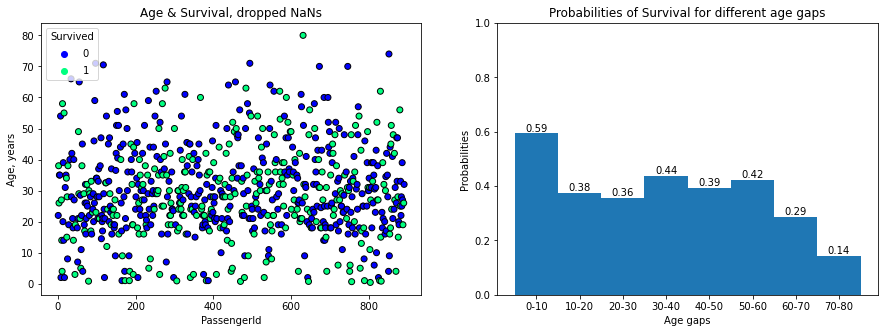

In [12]:
# Analyzing the ages of people (using scatterplot):

fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(15, 5))

# 1. Dropping NaNs:

y = main_data.dropna(subset=["Age"])["Age"]
x = main_data.dropna(subset=["Age"]).index
c = main_data.dropna(subset=["Age"])["Survived"]

scatter1 = ax1.scatter(x=x, y=y, c=c, cmap='winter', edgecolors='black')
ax1.legend(*scatter1.legend_elements(), title="Survived", loc='upper left')
ax1.set(title="Age & Survival, dropped NaNs",
        ylabel="Age, years",
        xlabel="PassengerId");

# 2. Using probabilities:
bar1 = ax2.bar(x=[f"{year}-{year+10}" for year in years], height=probabilities, width=1)
ax2.set_ylim((0,1))
ax2.set(title="Probabilities of Survival for different age gaps",
        xlabel="Age gaps",
        ylabel="Probabilities");

ax2.bar_label(bar1, fmt='%.2f');

### Cabin correlation

In [13]:
# How many cabins we have and what format are they?
cabins = main_data.dropna(subset=["Cabin"])
cabins

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
...,...,...,...,...,...,...,...,...,...,...,...
872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C


In [14]:
# Let's get tickets capital letters:
cabin_letters = list()
for cabin in cabins["Cabin"]:
    letter = re.findall('[A-Z]', cabin)
    if len(letter) == 1:
        cabin_letters.append(letter)
    else:
        cabin_letters.append([letter[0]])
    
cabin_letters = np.array(cabin_letters).reshape([204])
cabin_letters[:5], np.unique(cabin_letters)

(array(['C', 'C', 'E', 'G', 'C'], dtype='<U1'),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], dtype='<U1'))

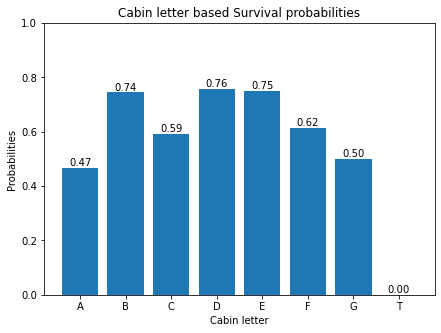

In [40]:
# Let's check whether the correlation between tickets and survival chances exists:

# Rearranging dataframe:
cabin_dict = defaultdict(list)
for number, index in enumerate(cabins.index):
    cabin_dict[cabins["Cabin"][index]] = cabin_letters[number]

cabins["Cabin"].replace(cabin_dict, inplace=True)

fig, ax = plt.subplots(figsize=(7, 5))
x = np.unique(cabin_letters)
y = cabins.groupby("Cabin").mean()["Survived"]

bar = ax.bar(x=x, height=y)
ax.set(title="Cabin letter based Survival probabilities",
       xlabel="Cabin letter",
       ylabel="Probabilities",
       ylim=[0, 1])

ax.bar_label(bar, fmt='%.2f');

## Implementation of analysis results